In [21]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [104]:
def armijo_step(gradient, x, **kwargs):
    f = kwargs["f"]
    alpha = 1
    x_next = x - alpha * gradient
    while f(x_next) > f(x) + 0.2 * alpha * gradient.dot(x_next - x):
        alpha *= 0.85
        x_next = x - alpha * gradient
    return alpha


In [87]:
from timeit import default_timer as timer

def GradientDescent(f, gradf, x0, epsilon, num_iter, alpha_search, **kwargs):
    x = x0.copy()
    iteration = 0
    grad_norms = []
    timestamps = []
    alpha = 1
    opt_arg = {"f": f, "grad_f": gradf, "epsilon": epsilon, 
               "iteration": iteration}
    for arg in kwargs:
        opt_arg[arg] = kwargs[arg]
    start = timer()
    while opt_arg["iteration"] < num_iter:
        gradient = gradf(x)
        alpha = alpha_search(gradient, x, **opt_arg)
        x = x - alpha * gradient
        opt_arg["iteration"] += 1
        grad_norms.append(np.linalg.norm(gradf(x)))
        curr = timer()
        timestamps.append((curr - start) * 1000)
        if np.linalg.norm(gradf(x)) < epsilon:
            break
    end = timer()
    time = (end - start) * 1000
    result = {"x": x, "conv_values": grad_norms, 
              "num_iter": len(grad_norms), "time": time, 
              "time_per_iter": time / len(grad_norms), 
              "timestamps": timestamps}
    return result

In [88]:
def pure(*args, **kwargs):
    return 1

def damped(*args, **kwargs):
    return kwargs['alpha']

def grad_conv(x, **kwargs):
    return np.linalg.norm(kwargs['gradf'](x))

def bb_first(g, s):
    return g.dot(s) / g.dot(g)

def bb_second(g, s):
    return s.dot(s) / g.dot(s)

In [89]:
def Newton(f, gradf, hessf, x0, epsilon, num_iter,
           step_selection=pure, convergence=grad_conv, **kwargs):
    x = x0.copy()
    iteration = 0
    opt_args = {"f": f, "gradf": gradf}
    opt_args.update(kwargs)
    conv_values = []
    timestamps = []
    start = timer()
    while iteration < num_iter:
        if len(x) > 1:
            h = np.linalg.solve(hessf(x), -gradf(x))
        else:
            h = -1 / hessf(x)[0] * gradf(x)[0]
        alpha = step_selection(x, h, **opt_args)
        x = x + alpha * h
        conv_value = convergence(x, **opt_args)
        timestamps.append((timer() - start) * 1000) 
        conv_values.append(conv_value)
        if conv_value < epsilon:
            break
        iteration += 1

    end = timer()
    time = (end - start) * 1000
    result = {"x": x, "conv_values": conv_values, 
              "num_iter": len(conv_values), "time": time, 
              "time_per_iter": time / len(conv_values), 
              "timestamps": timestamps}
    return result

In [90]:
def QuasiNewton(f, gradf, hessf, x0, epsilon, num_iter,  # hessf not used
                step_selection=bb_first, convergence=grad_conv, **kwargs):
    x_prev = x0.copy()
    iteration = 0
    opt_args = {"f": f, "gradf": gradf}
    opt_args.update(kwargs)
    conv_values = []
    timestamps = []
    start = timer()
    alpha = 0.0001
    while iteration < num_iter:
        current_grad = gradf(x_prev)
        if iteration != 0:
            g = current_grad - prev_grad
            alpha = step_selection(g, s)
        x_next = x_prev - alpha * current_grad
        conv_value = convergence(x_next, **opt_args)
        conv_values.append(conv_value)
        curr = timer()
        timestamps.append((curr - start) * 1000)
        if (grad_conv(x_next, **opt_args) < epsilon) or (conv_value < epsilon):
            break
        prev_grad = current_grad
        s = x_next - x_prev
        x_prev = x_next
        iteration += 1

    end = timer()
    time = (end - start) * 1000
    result = {"x": x_prev, "conv_values": conv_values, 
              "num_iter": len(conv_values), "time": time, 
              "time_per_iter": time / len(conv_values), 
              "timestamps": timestamps}
    return result

In [91]:
def f_stoch(x):
    return np.linalg.norm(A0 @ x - b)**2 + 1 / 3 * np.linalg.norm(A1 @ x)**2

def gradf_stoch(x):
    return 2 * A0.T @ (A0 @ x - b) + 2 / 3 * A1.T @ A1 @ x

def hessf_stoch(x):
    return 2 * A0.T @ A0 + 2 / 3 * A1.T @ A1

In [92]:
N = 20
M = 10
A0 = np.random.uniform(-1, 1, (N, M)) * 10
A1 = np.random.uniform(-1, 1, (N, M))
b = np.random.uniform(-10, 10, N)
x0 = np.random.rand(M)

In [106]:
def show_res(method, axs, **kwargs):
    result = method(**kwargs)
    label = method.__name__ 
    if kwargs['descr']:
        label += ', ' + kwargs['descr']
    print(label)
    axs[0].semilogy(np.arange(1, result['num_iter'] + 1), result['conv_values'], label=label)
    axs[1].semilogy(result['timestamps'], result['conv_values'], label=label)
    for key,value in result.items():
        if key not in ['timestamps', 'conv_values']:
            print(key, ": ", value)
    print('\n')
    

def compare(x0, epsilon, num_iter):
    fig, axs = plt.subplots(2, 1, figsize=(12, 12), dpi=200)
    show_res(GradientDescent, axs, f=f_stoch, gradf=gradf_stoch, x0=x0, epsilon=epsilon,
             num_iter=num_iter, alpha_search=armijo_step, descr='Armijo step')
    show_res(Newton, axs, f=f_stoch, gradf=gradf_stoch, hessf=hessf_stoch, x0=x0, epsilon=epsilon,
             num_iter=num_iter, step_selection=damped, convergence=grad_conv, alpha=0.5,
             descr='damped, alpha = 0.5')
    show_res(QuasiNewton, axs, f=f_stoch, gradf=gradf_stoch, hessf=hessf_stoch, x0=x0, epsilon=epsilon,
             num_iter=num_iter, step_selection=bb_second, convergence=grad_conv, descr='bb_second')
    axs[0].set_xlabel("Number of iterations")
    axs[0].set_ylabel(r"$||\nabla f(x_k)||$")
    axs[1].set_xlabel("Time (ms)")
    axs[1].set_ylabel(r"$||\nabla f(x_k)||$")
    axs[0].legend()
    axs[1].legend()

    fig.suptitle("Comparison of optimization methods", y=0.92, fontsize=15)
    plt.show()

GradientDescent, Armijo step
x :  [-0.0528945  -0.30167256 -0.16997313  0.06252796  0.47693534  0.36212258
 -0.38137935  0.0423397   0.10152337 -0.09227464]
num_iter :  151
time :  191.10906700370833
time_per_iter :  1.265622960289459


Newton, damped, alpha = 0.5
x :  [-0.0528945  -0.30167256 -0.16997313  0.06252796  0.47693534  0.36212258
 -0.38137935  0.0423397   0.10152337 -0.09227464]
num_iter :  31
time :  3.814821000560187
time_per_iter :  0.12305874195355442


QuasiNewton, bb_second
x :  [-0.0528945  -0.30167256 -0.16997313  0.06252796  0.47693534  0.36212258
 -0.38137935  0.0423397   0.10152337 -0.09227464]
num_iter :  49
time :  4.11316700046882
time_per_iter :  0.08394218368303714




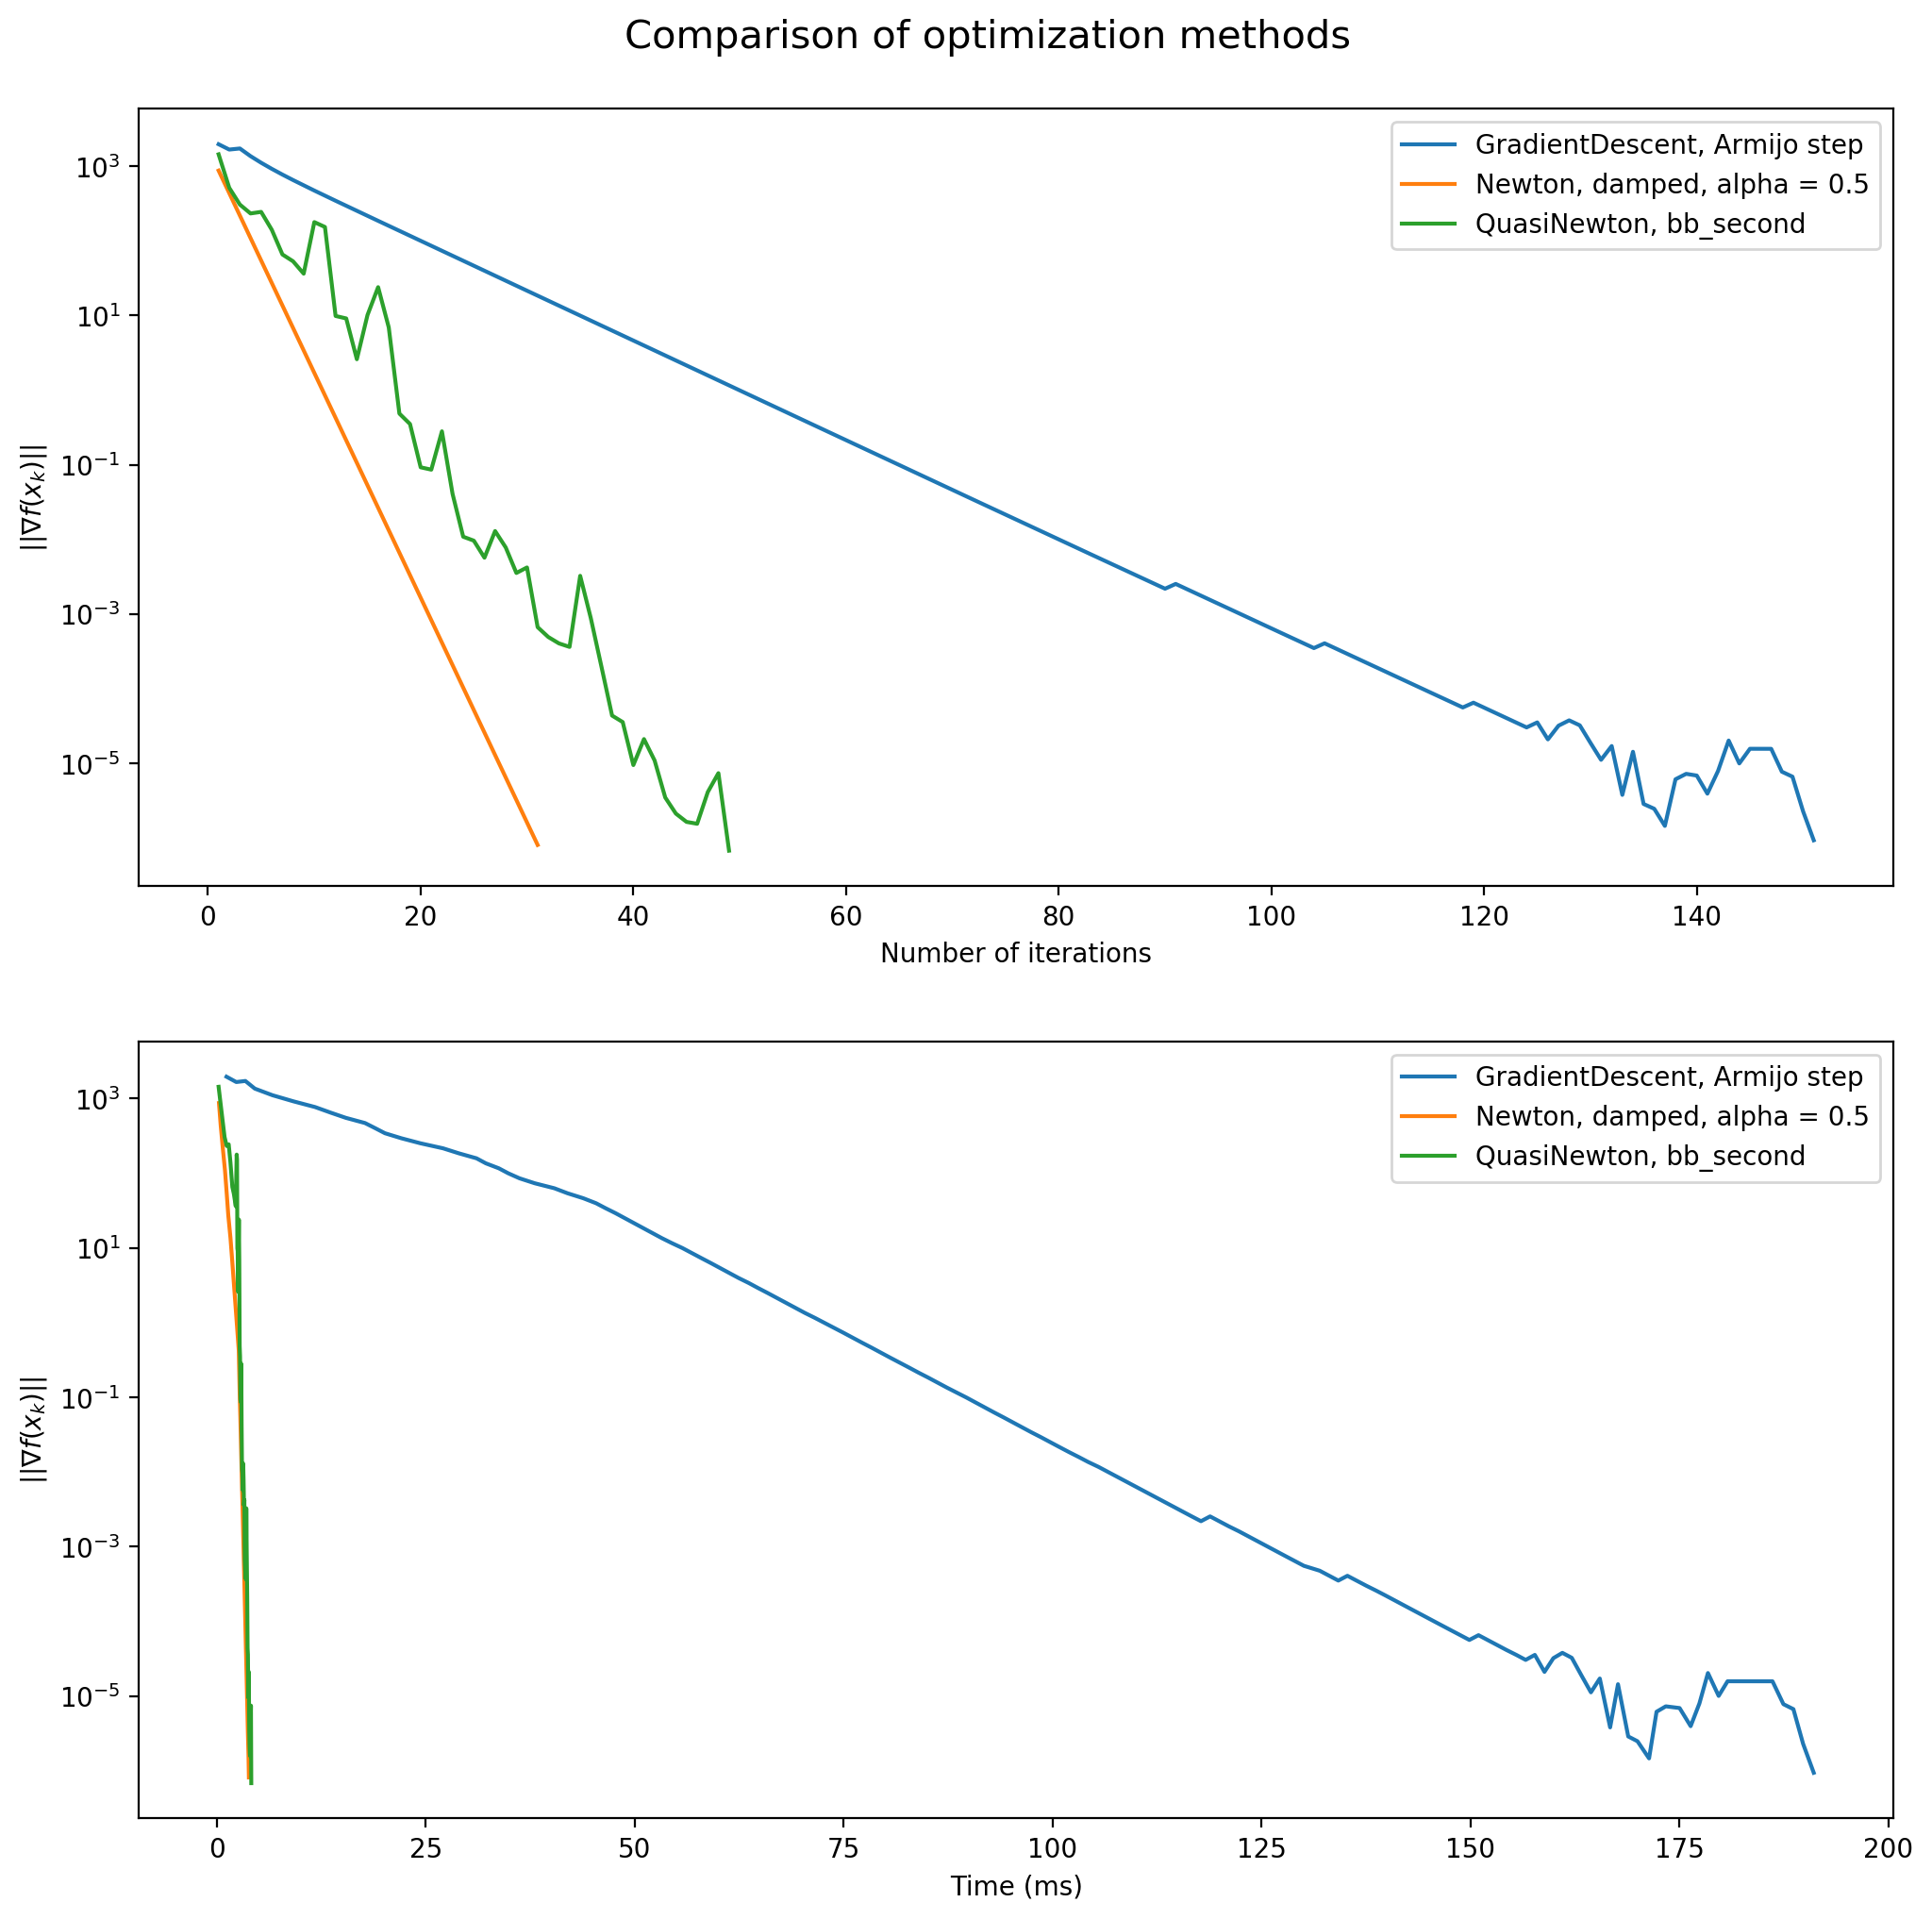

In [107]:
compare(x0, 10**(-6), 300)